In [1]:
#!git clone https://github.com/qwerty29544/superresolution_nn.git

Cloning into 'superresolution_nn'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 68 (delta 24), reused 47 (delta 7), pack-reused 0
Unpacking objects: 100% (68/68), 11.74 MiB | 6.37 MiB/s, done.


In [33]:
#!mv /content/superresolution_nn/ipynb/model_params model_params

In [1]:
import random
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})

my_seed = 123
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
def gauss(x, mean = 0.0, var = 0.0001, amp = 1.0):
    return amp * np.exp(- (x - mean) ** 2 / (2 * var))



def signal_gauss(x, alpha0 = [0.01, -0.01], scale = 0.00001, amp = [1.0, 1.0]):
    result = 0
    for idx, pos in enumerate(alpha0):
        result += gauss(x, pos, scale, amp[idx])
    return result



def Fexp(alpha, n = 0, k = 2 * np.pi, d = 0.7, sign = 1):
    return np.exp(sign * 1j * alpha * n * k * d)



def Cn_deltaf_compute(n, k, d, alpha0 = [0.01, -0.01]):
    result = 0
    for target in alpha0:
        result += Fexp(target, n, k, d)
    return result



def U_compute(alpha, Cn, k, d):
    result = 0
    M = len(Cn)
    delta = (M - 1) // 2
    for n, C in enumerate(Cn):
        result += C * Fexp(alpha, n - delta, k, d, -1)
    return result

In [38]:
K = 20              # Реальное количество излучателей
NP = 400            # Виртуальное количество излучателей
k = 2 * np.pi       # Волновое число
d = 0.7             # Расстояние между излучателями

alpha = np.linspace(-0.06, 0.06, 2000)  # Угловое разрешение области
targets = [-0.025, 0.025]              # Положения целей
amplitude = [300, 300]

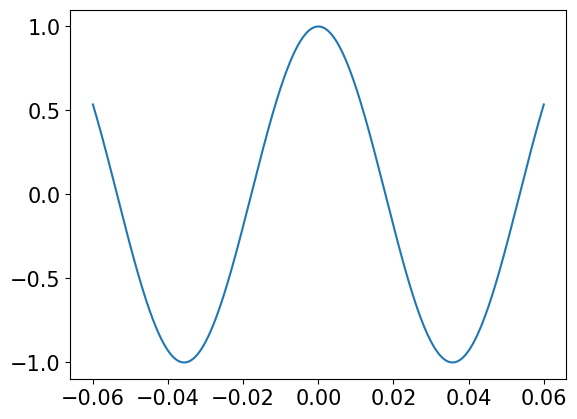

In [39]:
plt.plot(alpha, Fexp(alpha, K))

In [40]:
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)


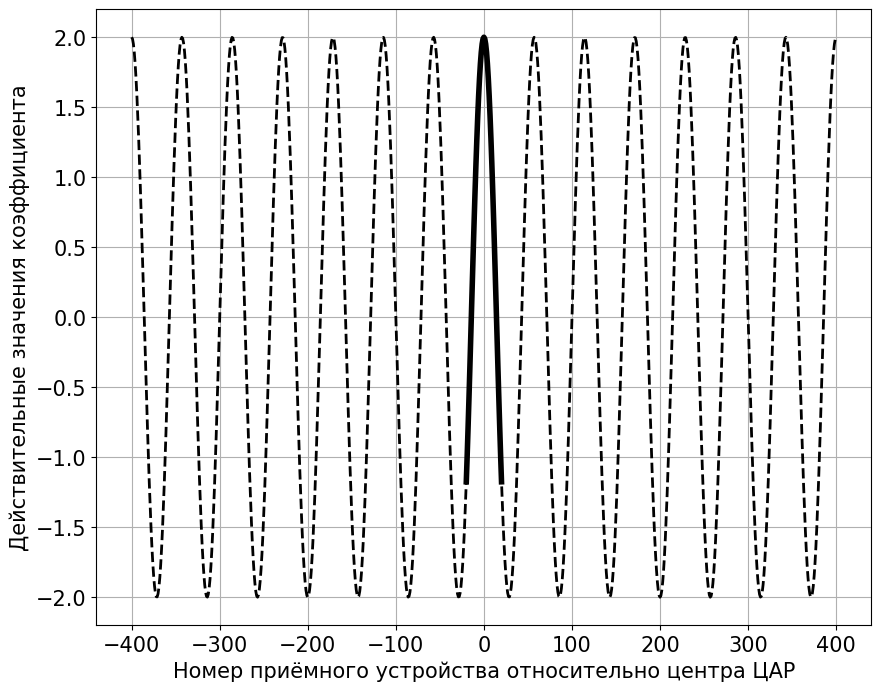

In [41]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.real(Cn_virtual), label = "Виртуальная система, желаемые значения", 
         c = "#000000", linestyle = "--",linewidth = 2)
plt.plot(n_real, np.real(Cn_real), label = "Физическая система, реальные значения", 
         c = "#000000", linestyle = "-",linewidth = 4)
#plt.legend()
plt.grid()
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Действительные значения коэффициента")
plt.savefig("../rmarkdown_report/Begin_virtual.png")

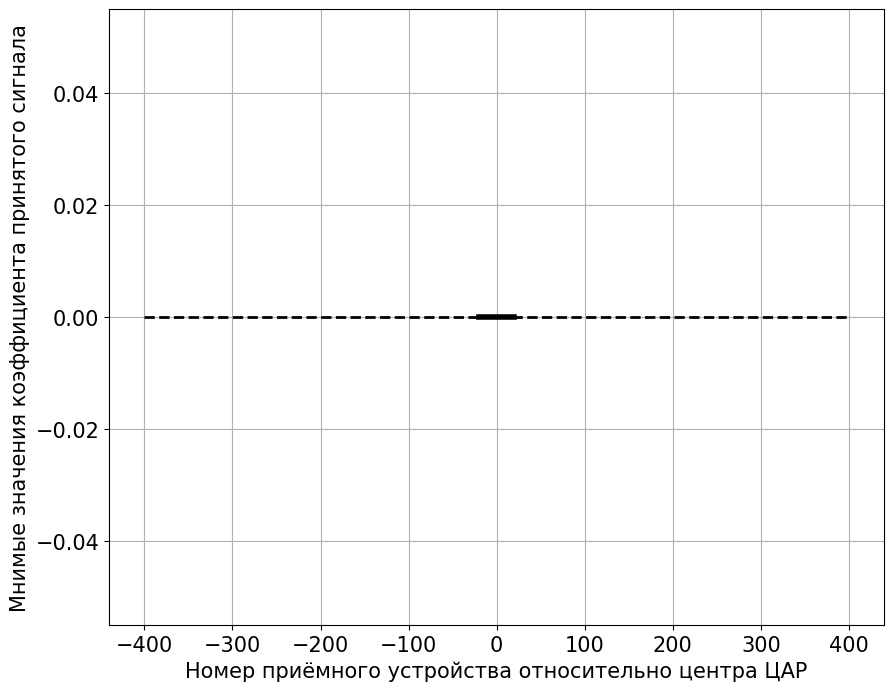

In [42]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.imag(Cn_virtual), label = "Виртуальная система, желаемые значения", 
         c = "#000000", linestyle = "--", linewidth = 2)
plt.plot(n_real, np.imag(Cn_real), label = "Физическая система, реальные значения", 
         c = "#000000", linestyle = "-", linewidth = 4)
#plt.legend()
plt.grid()
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Мнимые значения коэффициента принятого сигнала")
plt.savefig("../rmarkdown_report/Begin_virtual_imag.png")

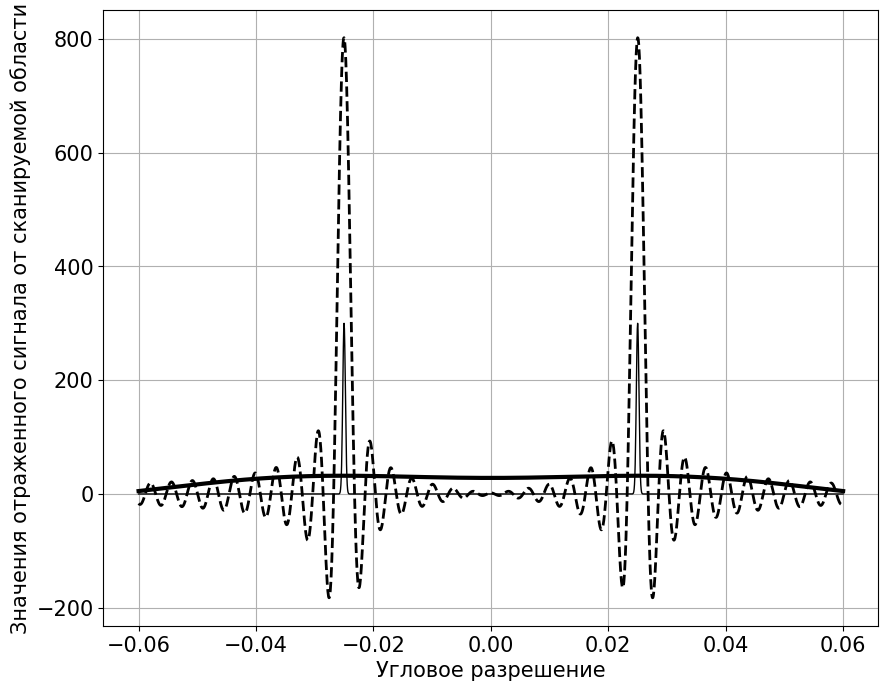

In [43]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(alpha, signals, label = "Функции целей", c = "#000000", linewidth = 1)
plt.plot(alpha, np.real(U_real), label = "Принятый сигнал, физическая система", c = "#000000", linewidth = 3)
plt.plot(alpha, np.real(U_virtual), label = "Принятый сигнал, виртуальная система", c = "#000000", linewidth = 2, linestyle = "--")
#plt.legend()
plt.grid()
plt.xlabel("Угловое разрешение")
plt.ylabel("Значения отраженного сигнала от сканируемой области")
plt.savefig("../rmarkdown_report/Begin_target.png")

## Определение Минимального расстояния Разрешения сигнала по критерию Рэлея

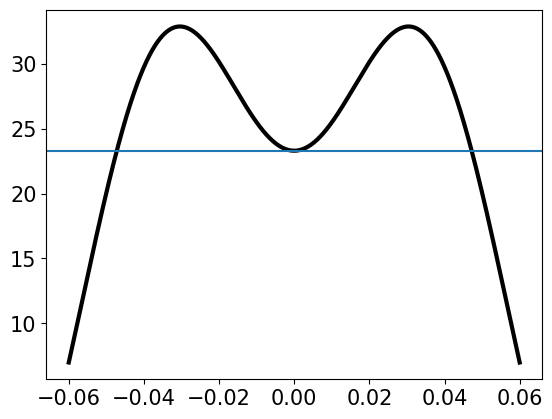

In [60]:
K = 20              # Реальное количество излучателей
NP = 400            # Виртуальное количество излучателей
k = 2 * np.pi       # Волновое число
d = 0.7             # Расстояние между излучателями
alpha0 = 0.06

alpha = np.linspace(-alpha0, alpha0, 2001)  # Угловое разрешение области

n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей

for alpha_iter in alpha[:len(alpha)//2+1]:
    targets = [-alpha_iter, alpha_iter]              # Положения целей
    Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
    # Реально принятый сигнал
    U_real = U_compute(alpha, Cn_real, k, d)
    if np.max(np.real(U_real))/np.sqrt(2) <= np.real(U_real)[len(alpha)//2]:
        break
    

plt.plot(alpha, np.real(U_real), label = "Принятый сигнал, физическая система", c = "#000000", linewidth = 3)
plt.axline((-0.04, np.max(np.real(U_real))/np.sqrt(2)), (0.04, np.max(np.real(U_real))/np.sqrt(2)))

Минимальное расстояние между целями $\cfrac{Q_p}{2} = 0.0265$, при 

## Определение данных и нейросети

In [8]:
def create_data(number_of_samples = 10000, n_real = 20, n_virtual = 400, target_bounds = [-0.04, 0.04],
                k = 1, d = 1, noised = False, noise_level = 0.4, seed = 123):
    data_x = np.zeros((4 * number_of_samples, n_real * 2 + 1)) + 0j
    data_y = np.zeros((4 * number_of_samples, n_virtual * 2 + 1)) + 0j

    np.random.seed(123)
    real = np.arange(-n_real, n_real + 1)                 # Реальное перечисление номеров излучателей
    virtual = np.arange(-n_virtual, n_virtual + 1)            # Идеальное (виртуальное) число излучателей

    for sample_num in np.arange(number_of_samples):
        targets = [np.random.uniform(target_bounds[0], target_bounds[0] * 0.0001, 1),\
                  np.random.uniform(target_bounds[1] * 0.0001, target_bounds[1], 1)]
        data_x[sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)

    for sample_num in np.arange(number_of_samples):
        targets = []
        targets.append(np.random.uniform(target_bounds[0], target_bounds[0] * 0.05, 1))
        targets.append(np.abs(targets[0]))
        data_x[number_of_samples + sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[number_of_samples + sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)

    for sample_num in np.arange(number_of_samples):
        targets = []
        targets.append(np.random.uniform(target_bounds[0], 0.5 * target_bounds[0], 1))
        targets.append(np.random.uniform(0.5 * target_bounds[0], 0, 1))
        data_x[2 * number_of_samples + sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[2 * number_of_samples + sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)

    for sample_num in np.arange(number_of_samples):
        targets = []
        targets.append(np.random.uniform(0, target_bounds[1] * 0.5, 1))
        targets.append(np.random.uniform(0.5 * target_bounds[1], target_bounds[1], 1))
        data_x[3 * number_of_samples + sample_num, :] = Cn_deltaf_compute(real, k, d, targets)
        data_y[3 * number_of_samples + sample_num, :] = Cn_deltaf_compute(virtual, k, d, targets)



    return data_x, data_y

In [9]:
X, Y = create_data(number_of_samples = 10000, k = k, d = d)
order = np.random.permutation(X.shape[0])
X = X[order]
Y = Y[order]

X_val, Y_val = create_data(number_of_samples = 1000, k = k, d = d)
order_val = np.random.permutation(X_val.shape[0])
X_val = X_val[order_val]
Y_val = Y_val[order_val]

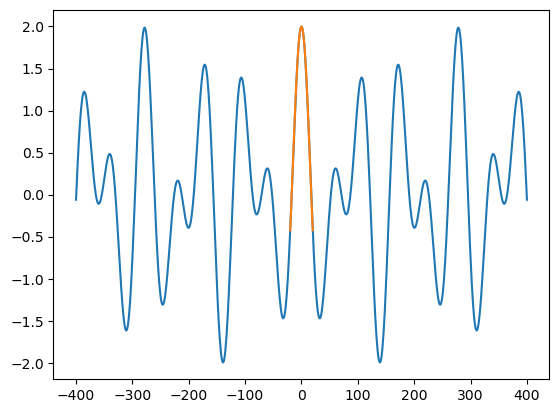

In [72]:
plt.plot(np.arange(-NP, NP+1), np.real(Y[8002,:]))
plt.plot(np.arange(-K, K + 1), np.real(X[8002,:]))

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(my_seed)
torch.use_deterministic_algorithms(False)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = self.dropout(x)
        x = F.selu(self.fc2(x))
        x = self.dropout(x)
        x = F.selu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

    def inference(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return x

In [11]:
X_tensor_real  = torch.tensor(np.real(X), dtype = torch.float, device=device)
Y_tensor_real = torch.tensor(np.real(Y), dtype = torch.float, device=device)
X_val_tensor_real = torch.tensor(np.real(X_val), dtype = torch.float, device=device)
Y_val_tensor_real = torch.tensor(np.real(Y_val), dtype = torch.float, device=device)

X_tensor_imag  = torch.tensor(np.imag(X), dtype = torch.float, device=device)
Y_tensor_imag = torch.tensor(np.imag(Y), dtype = torch.float, device=device)
X_val_tensor_imag = torch.tensor(np.imag(X_val), dtype = torch.float, device=device)
Y_val_tensor_imag = torch.tensor(np.imag(Y_val), dtype = torch.float, device=device)

In [12]:
model_superresolution_real = RegressionNet(input_size = X.shape[1], hidden_size = 500,
                                      output_size = Y.shape[1], dropout_prob = 0.00)
model_superresolution_imag = RegressionNet(input_size = X.shape[1], hidden_size = 500,
                                      output_size = Y.shape[1], dropout_prob = 0.00)

In [13]:
model_superresolution_real.load_state_dict(torch.load("model_params_real", map_location = device))
model_superresolution_imag.load_state_dict(torch.load("model_params_imag", map_location = device))

<All keys matched successfully>

In [15]:
rate = 1e-4
batch_size = 400
num_epochs = 400

criterion = nn.MSELoss()
optimizer_real = torch.optim.Adam(model_superresolution_real.parameters(), lr = rate)
optimizer_imag = torch.optim.Adam(model_superresolution_imag.parameters(), lr = rate)

optimizer_real.zero_grad()
optimizer_imag.zero_grad()

In [26]:
model_superresolution_real.to(device)
model_superresolution_imag.to(device)
for epoch in range(num_epochs):
    running_loss_real = 0.0
    running_loss_imag = 0.0
    order = np.random.permutation(X_tensor_real.shape[0])
    for i in range(0, X_tensor_real.shape[0], batch_size): # пакеты по 10 изображений
        indexes = order[i:i+batch_size]
        batch_inputs_real = X_tensor_real[indexes]
        batch_labels_real = Y_tensor_real[indexes]

        batch_inputs_imag = X_tensor_imag[indexes]
        batch_labels_imag = Y_tensor_imag[indexes]

        # обнуление градиентов
        optimizer_real.zero_grad()
        optimizer_imag.zero_grad()

        # передача данных через модель
        outputs_real = model_superresolution_real(batch_inputs_real)
        outputs_imag = model_superresolution_imag(batch_inputs_imag)

        # расчет функции потерь
        loss_real = criterion(outputs_real, batch_labels_real)
        loss_imag = criterion(outputs_imag, batch_labels_imag)

        # обратное распространение ошибки и обновление весов
        loss_real.backward()
        loss_imag.backward()
        optimizer_real.step()
        optimizer_imag.step()
        # суммирование потерь на каждой эпохе
        running_loss_real += loss_real.item()
        running_loss_imag += loss_imag.item()

    if (epoch+1) % 3 == 0:
        with torch.no_grad():
            loss_val_real = criterion(model_superresolution_real.inference(X_val_tensor_real), Y_val_tensor_real)
            loss_val_imag = criterion(model_superresolution_imag.inference(X_val_tensor_imag), Y_val_tensor_imag)
            print("Val Epoch %d loss real: $.5f" % (epoch + 1), loss_val_real.item())
            print("Val Epoch %d loss imag: $.5f" % (epoch + 1), loss_val_imag.item())

    # вывод потерь на каждой эпохе
    print('Epoch %d loss real: %.5f' % (epoch + 1, running_loss_real / X_tensor_real.shape[0] * batch_size))
    print('Epoch %d loss imag: %.5f' % (epoch + 1, running_loss_imag / X_tensor_imag.shape[0] * batch_size))

Epoch 1 loss real: 0.05254
Epoch 1 loss imag: 0.10655
Epoch 2 loss real: 0.05062
Epoch 2 loss imag: 0.10791
Val Epoch 3 loss real: $.5f 0.046108923852443695
Val Epoch 3 loss imag: $.5f 0.10571524500846863
Epoch 3 loss real: 0.04980
Epoch 3 loss imag: 0.10653
Epoch 4 loss real: 0.05196
Epoch 4 loss imag: 0.10612
Epoch 5 loss real: 0.05054
Epoch 5 loss imag: 0.10584
Val Epoch 6 loss real: $.5f 0.05797712132334709
Val Epoch 6 loss imag: $.5f 0.10706476867198944
Epoch 6 loss real: 0.05001
Epoch 6 loss imag: 0.10513
Epoch 7 loss real: 0.05251
Epoch 7 loss imag: 0.10524
Epoch 8 loss real: 0.05082
Epoch 8 loss imag: 0.10629
Val Epoch 9 loss real: $.5f 0.0644269734621048
Val Epoch 9 loss imag: $.5f 0.10590571165084839
Epoch 9 loss real: 0.04894
Epoch 9 loss imag: 0.10607
Epoch 10 loss real: 0.05893
Epoch 10 loss imag: 0.10649
Epoch 11 loss real: 0.05236
Epoch 11 loss imag: 0.10630
Val Epoch 12 loss real: $.5f 0.05368427559733391
Val Epoch 12 loss imag: $.5f 0.10392433404922485
Epoch 12 loss re

In [27]:
torch.save(model_superresolution_real.state_dict(), "model_params_real")
torch.save(model_superresolution_imag.state_dict(), "model_params_imag")

In [14]:
model_superresolution_real.to(torch.device("cpu"))
model_superresolution_imag.to(torch.device("cpu"))

RegressionNet(
  (fc1): Linear(in_features=41, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=801, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [69]:
targets = [-0.005, 0.005]              # Положения целей
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

Cn_nn = model_superresolution_real(torch.tensor(np.real(Cn_real), dtype = torch.float)).detach() + 1j * model_superresolution_imag(torch.tensor(np.imag(Cn_real), dtype = torch.float)).detach()

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)

# Принятый сигнал виртуальной системой
U_nn = U_compute(alpha, Cn_nn, k, d)

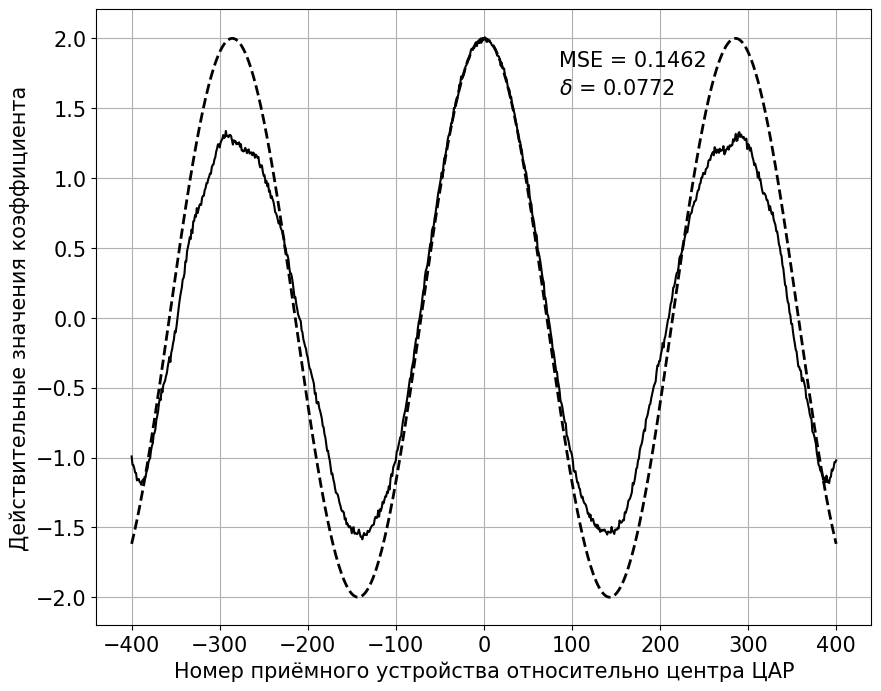

In [70]:
d11 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]
D11 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / np.sum((np.real(Cn_virtual)) ** 2)

plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.real(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.real(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.grid()
plt.text(85,
         1.8,
         "MSE = %.4f" % d11,
        fontsize = 15)
plt.text(85,
         1.6,
         "$\delta$ = %.4f" % D11,
        fontsize = 15)
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Действительные значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual1_real.png")

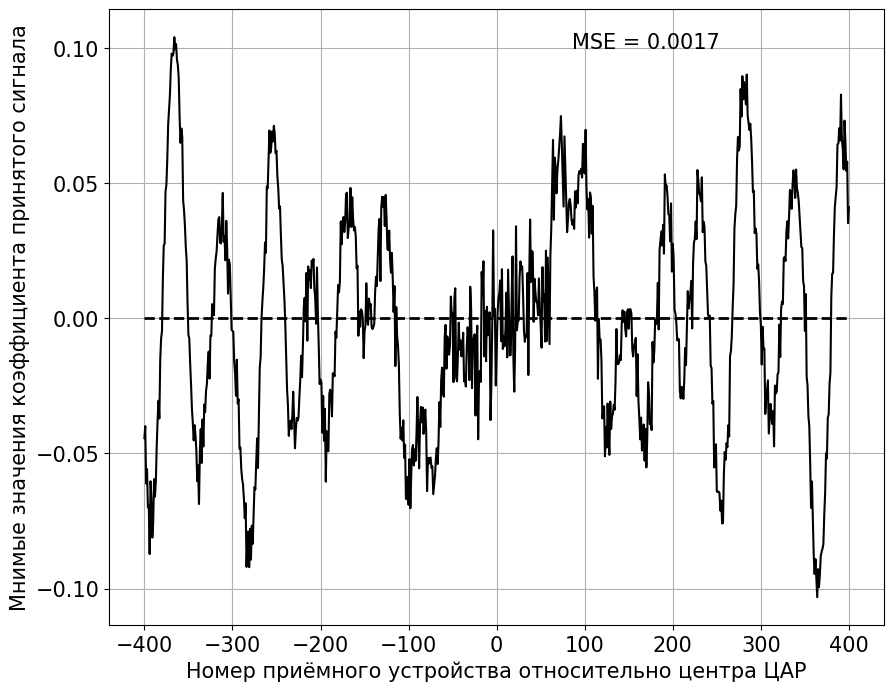

In [71]:
d12 = np.sum((np.imag(Cn_virtual) - np.imag(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]


plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.imag(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.imag(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.text(85,
         0.10,
         "MSE = %.4f" % d12,
        fontsize = 15)
plt.grid()
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Мнимые значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual1_imag.png")

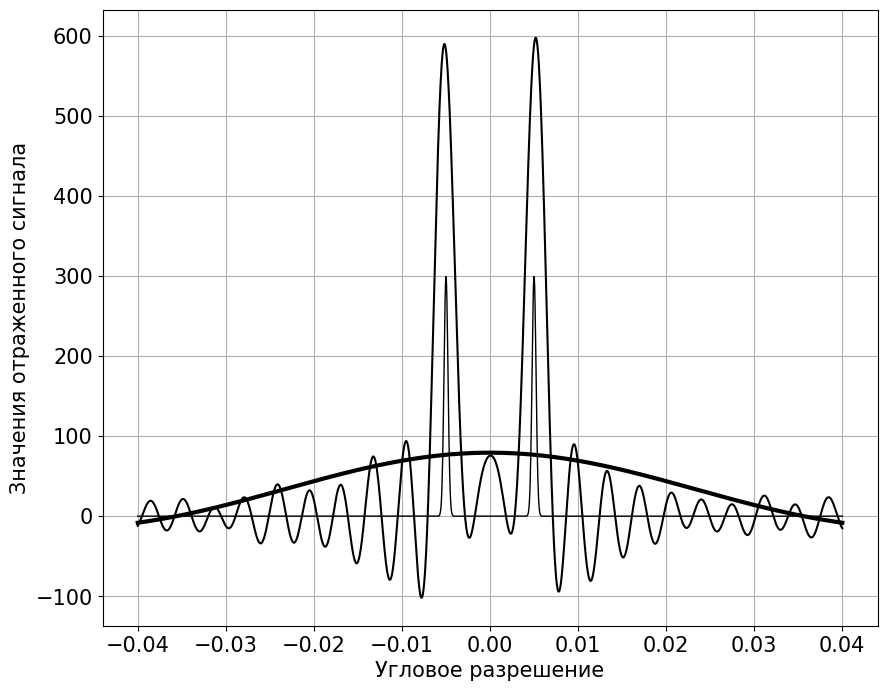

In [72]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(alpha, signals, label = "Функции целей", c = "#000000", linewidth = 1)
plt.plot(alpha, np.real(U_real), label = "Принятый сигнал, физическая система", c = "#000000", linewidth = 3)
#plt.plot(alpha, np.real(U_virtual), label = "Принятый сигнал, виртуальная система", c = "#000000", linewidth = 2, linestyle = "--")
plt.plot(alpha, np.real(U_nn), label = "Принятый сигнал, нейронная сеть", c = "#000000")
#plt.legend()
plt.grid()
plt.xlabel("Угловое разрешение")
plt.ylabel("Значения отраженного сигнала")
plt.savefig("../rmarkdown_report/Complete1_target.png")

## Несимметричные цели

In [73]:
targets = [-0.007, 0.012]              # Положения целей
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

Cn_nn = model_superresolution_real(torch.tensor(np.real(Cn_real), dtype = torch.float)).detach() + 1j * model_superresolution_imag(torch.tensor(np.imag(Cn_real), dtype = torch.float)).detach()

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)

# Принятый сигнал виртуальной системой
U_nn = U_compute(alpha, Cn_nn, k, d)

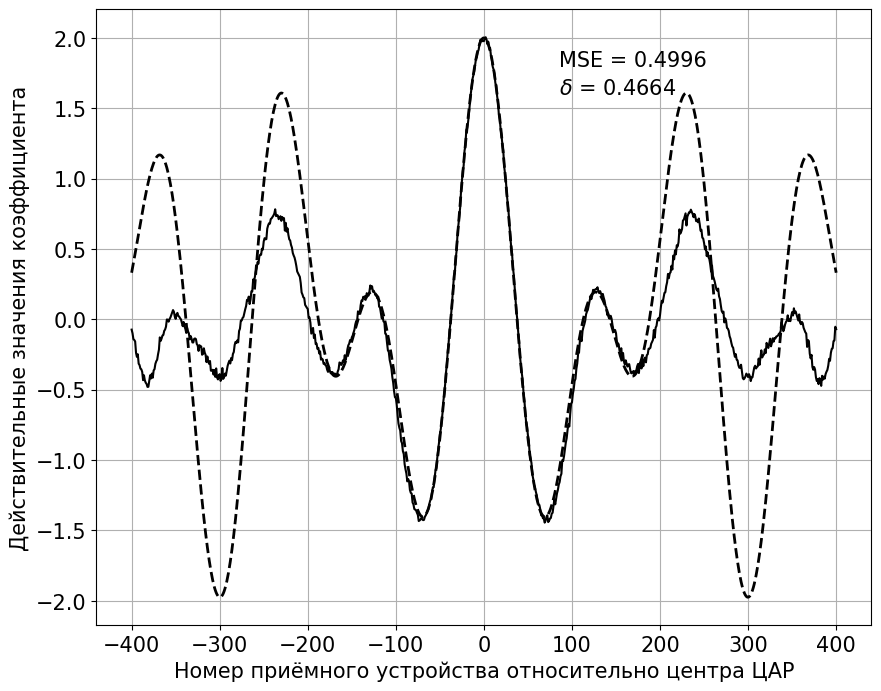

In [74]:
d21 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]
D21 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / np.sum((np.real(Cn_virtual)) ** 2)

plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.real(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.real(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.grid()
plt.text(85,
         1.8,
         "MSE = %.4f" % d21,
        fontsize = 15)
plt.text(85,
         1.6,
         "$\delta$ = %.4f" % D21,
        fontsize = 15)
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Действительные значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual2_real.png")

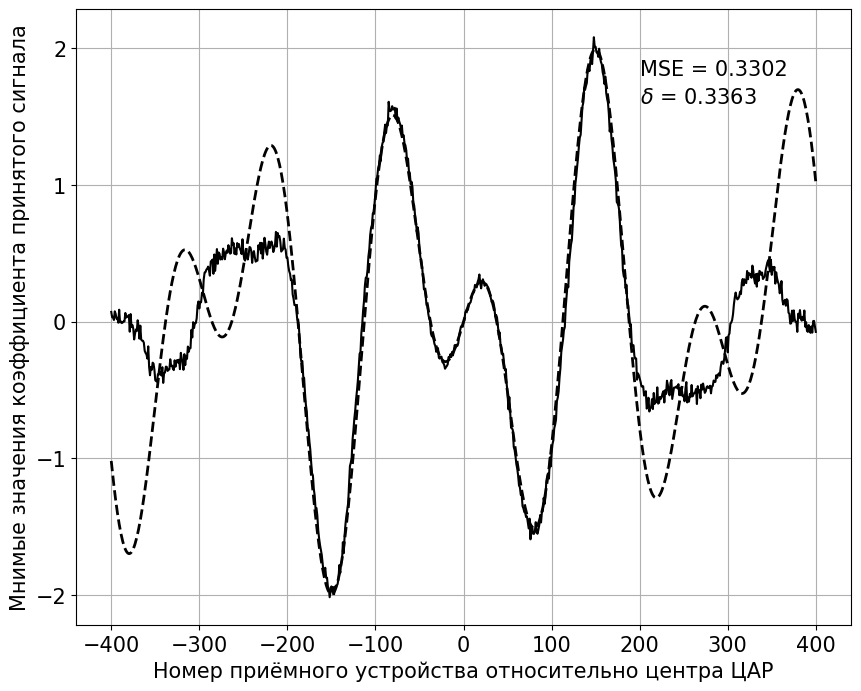

In [75]:
d22 = np.sum((np.imag(Cn_virtual) - np.imag(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]
D22 = np.sum((np.imag(Cn_virtual) - np.imag(np.array(Cn_nn))) ** 2) / np.sum((np.imag(Cn_virtual)) ** 2)


plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.imag(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.imag(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.text(200,
         1.8,
         "MSE = %.4f" % d22,
        fontsize = 15)
plt.text(200,
         1.6,
         "$\delta$ = %.4f" % D22,
        fontsize = 15)
plt.grid()
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Мнимые значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual2_imag.png")

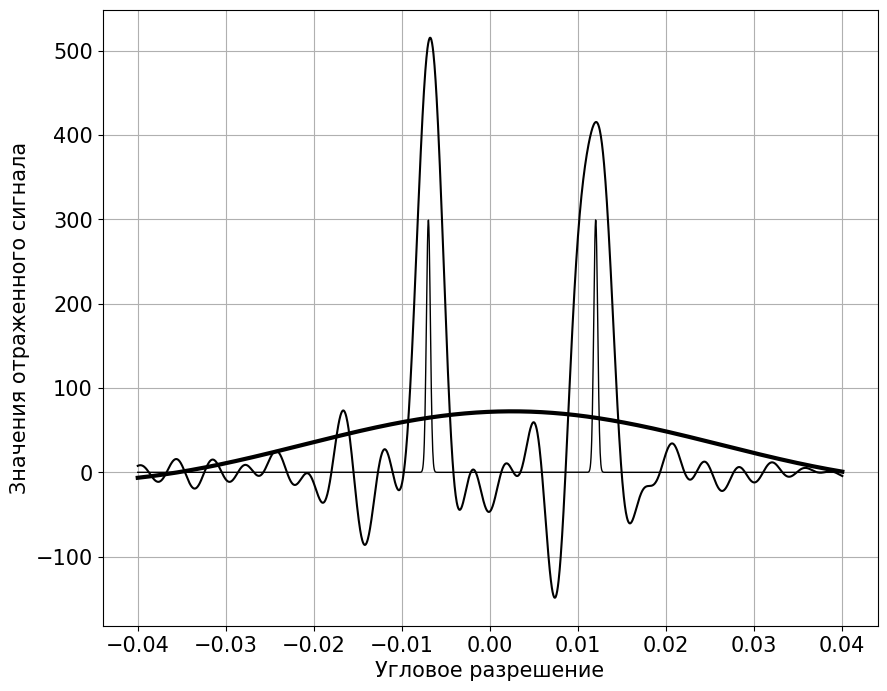

In [76]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(alpha, signals, label = "Функции целей", c = "#000000", linewidth = 1)
plt.plot(alpha, np.real(U_real), label = "Принятый сигнал, физическая система", c = "#000000", linewidth = 3)
#plt.plot(alpha, np.real(U_virtual), label = "Принятый сигнал, виртуальная система", c = "#000000", linewidth = 2, linestyle = "--")
plt.plot(alpha, np.real(U_nn), label = "Принятый сигнал, нейронная сеть", c = "#000000")
#plt.legend()
plt.grid()
plt.xlabel("Угловое разрешение")
plt.ylabel("Значения отраженного сигнала")
plt.savefig("../rmarkdown_report/Complete2_target.png")

## Односторонние цели

In [77]:
targets = [0.005, 0.0195]              # Положения целей
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

Cn_nn = model_superresolution_real(torch.tensor(np.real(Cn_real), dtype = torch.float)).detach() + 1j * model_superresolution_imag(torch.tensor(np.imag(Cn_real), dtype = torch.float)).detach()

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)

# Принятый сигнал виртуальной системой
U_nn = U_compute(alpha, Cn_nn, k, d)

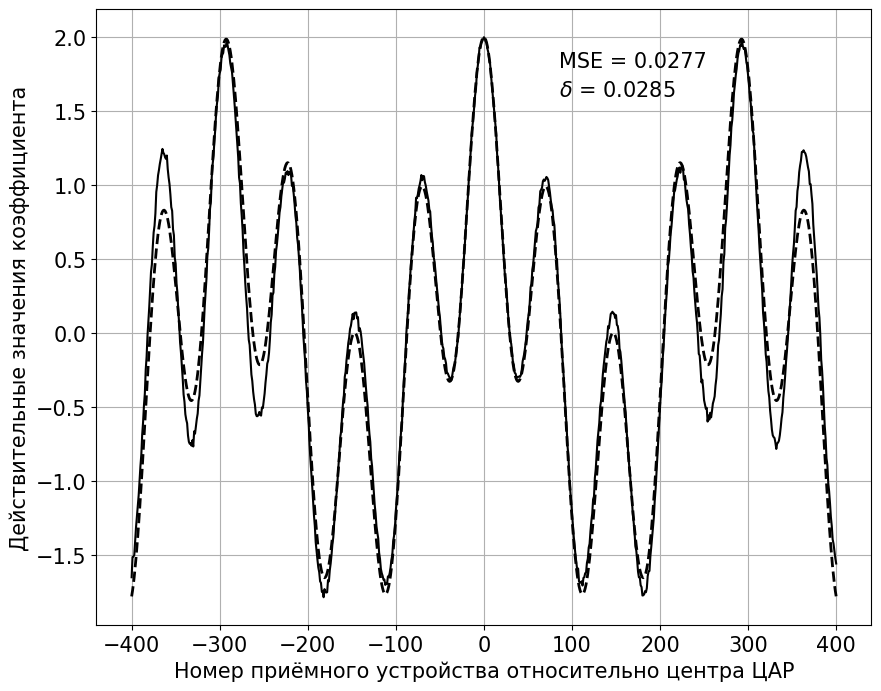

In [79]:
d31 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]
D31 = np.sum((np.real(Cn_virtual) - np.real(np.array(Cn_nn))) ** 2) / np.sum((np.real(Cn_virtual)) ** 2)

plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.real(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.real(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.grid()
plt.text(85,
         1.8,
         "MSE = %.4f" % d31,
        fontsize = 15)
plt.text(85,
         1.6,
         "$\delta$ = %.4f" % D31,
        fontsize = 15)
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Действительные значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual3_real.png")

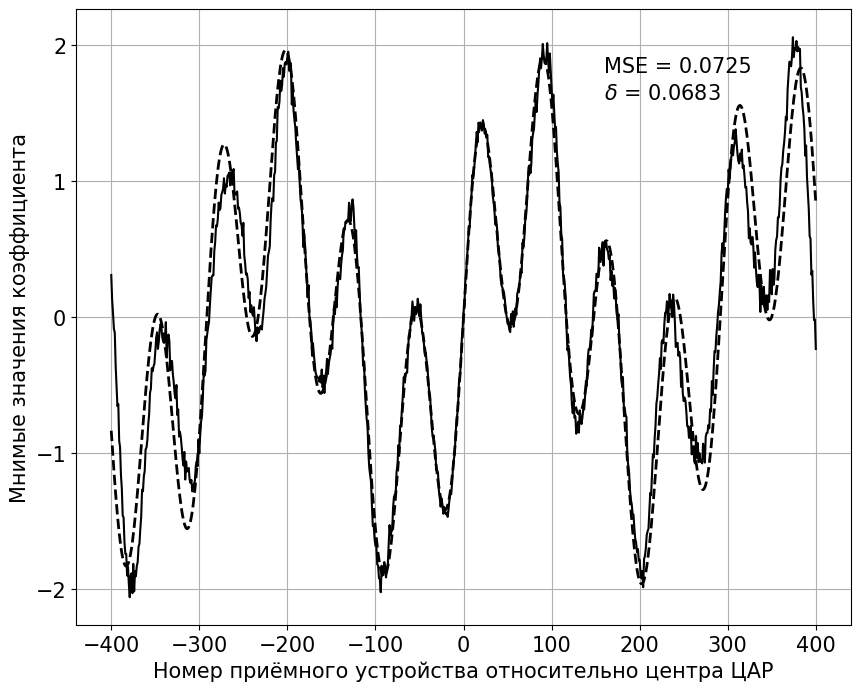

In [82]:
d32 = np.sum((np.imag(Cn_virtual) - np.imag(np.array(Cn_nn))) ** 2) / n_virtual.shape[0]
D32 = np.sum((np.imag(Cn_virtual) - np.imag(np.array(Cn_nn))) ** 2) / np.sum((np.imag(Cn_virtual)) ** 2)


plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(n_virtual, np.imag(Cn_virtual), label = "Виртуальная система, желаемые значения", linewidth = 2, c = "#000000", linestyle = "--")
plt.plot(n_virtual, np.imag(Cn_nn), label = "Прогноз нейросетевой моделью", linestyle = "-", c = "#000000")
#plt.legend()
plt.text(160,
         1.8,
         "MSE = %.4f" % d32,
        fontsize = 15)
plt.text(160,
         1.6,
         "$\delta$ = %.4f" % D32,
        fontsize = 15)
plt.grid()
plt.xlabel("Номер приёмного устройства относительно центра ЦАР")
plt.ylabel("Мнимые значения коэффициента")
plt.savefig("../rmarkdown_report/complete_virtual3_imag.png")

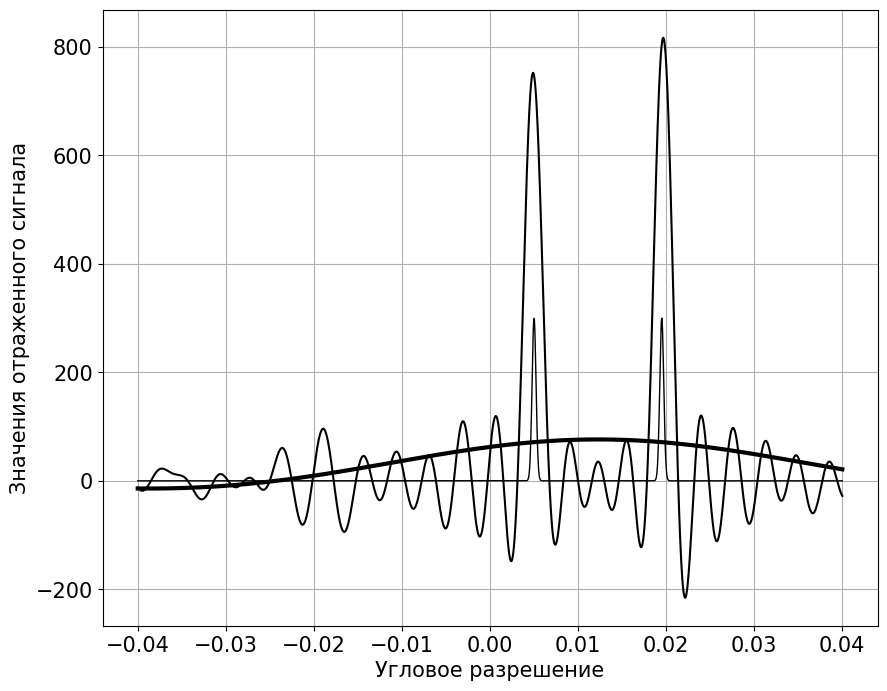

In [83]:
plt.figure(figsize = (10, 8), dpi = 100)
plt.plot(alpha, signals, label = "Функции целей", c = "#000000", linewidth = 1)
plt.plot(alpha, np.real(U_real), label = "Принятый сигнал, физическая система", c = "#000000", linewidth = 3)
#plt.plot(alpha, np.real(U_virtual), label = "Принятый сигнал, виртуальная система", c = "#000000", linewidth = 2, linestyle = "--")
plt.plot(alpha, np.real(U_nn), label = "Принятый сигнал, нейронная сеть", c = "#000000")
#plt.legend()
plt.grid()
plt.xlabel("Угловое разрешение")
plt.ylabel("Значения отраженного сигнала")
plt.savefig("../rmarkdown_report/Complete3_target.png")

## Определение для симметричных целей $Q_p$ и $Q_{0.5}$

In [ ]:
alpha = np.linspace(-alpha0, alpha0, 2001)  # Угловое разрешение области

n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей

for n in range(20, NP+1):
    q_p = []
    q05 = []
    for alpha_iter in alpha[:len(alpha)//2+1]:
        targets = [-alpha_iter, alpha_iter]              # Положения целей
        Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
        Cn_nn = model_superresolution_real(torch.tensor(np.real(Cn_real), dtype = torch.float)).detach() + 1j * model_superresolution_imag(torch.tensor(np.imag(Cn_real), dtype = torch.float)).detach()
        # Реально принятый сигнал
        U_nn = U_compute(alpha, Cn_nn[], k, d)
        if np.max(np.real(U_real))/np.sqrt(2) <= np.real(U_real)[len(alpha)//2]:
            break

            
targets = [-0.005, 0.005]              # Положения целей
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно

Cn_nn = model_superresolution_real(torch.tensor(np.real(Cn_real), dtype = torch.float)).detach() + 1j * model_superresolution_imag(torch.tensor(np.imag(Cn_real), dtype = torch.float)).detach()

# Принятый сигнал виртуальной системой
U_nn = U_compute(alpha, Cn_nn, k, d)

## SELU функция активации

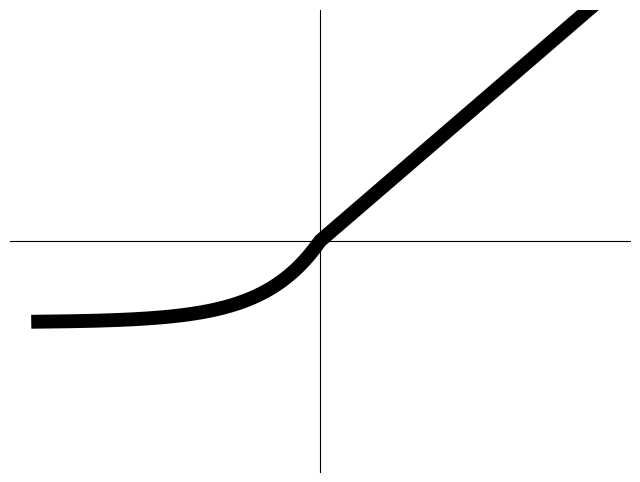

In [33]:
scale = 1.0507009873554804934193349852946
alpha = 1.6732632423544

x_grid = np.linspace(-5, 5, 10000)
zeros = np.zeros(10000)

SELU = lambda x: scale * (np.maximum(zeros, x) + np.minimum(zeros, alpha * (np.exp(x) - 1)))

plt.figure(figsize = (8,6), dpi = 100)
plt.plot(x_grid, SELU(x_grid),c="#000000", linewidth = 10)
plt.ylim((-5, 5))
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig("SELU.svg")

## Linear

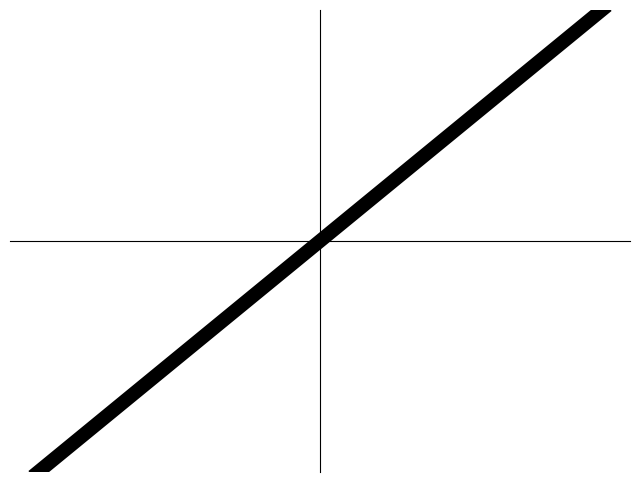

In [32]:
x_grid = np.linspace(-5, 5, 10000)


plt.figure(figsize = (8,6), dpi = 100)
plt.plot(x_grid, x_grid, c="#000000", linewidth = 10)
plt.ylim((-5, 5))
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig("Linear.svg")